In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import joblib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:

# Load and clean the dataset
df = pd.read_csv("kidney_disease.csv")
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [6]:
# Replace categorical values with numeric equivalents
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace({'yes':1, 'no':0})
df[['rbc', 'pc']] = df[['rbc', 'pc']].replace({'abnormal':1, 'normal':0})
df[['pcc', 'ba']] = df[['pcc', 'ba']].replace({'present':1, 'notpresent':0})
df[['appet']] = df[['appet']].replace({'good':1, 'poor':0, 'no':np.nan})
df['classification'] = df['classification'].replace({'ckd':1.0, 'ckd\t':1.0, 'notckd':0.0, 'no':0.0})
df.rename(columns={'classification': 'class'}, inplace=True)

In [7]:
# Further cleaning
df['pe'] = df['pe'].replace('good', 0) # Not having pedal edema is good
df['appet'] = df['appet'].replace('no', 0)
df['cad'] = df['cad'].replace('\tno', 0)
df['dm'] = df['dm'].replace({'\tno':0, '\tyes':1, ' yes':1, '':np.nan})
df.drop(columns='id', inplace=True)

In [8]:
# Drop less relevant columns for simplicity and fill missing values
df = df.drop(columns=["su", "rbc", "rc", "wc", "pot", "sod", "pc", "sg", "pcc", "ba", "pe", "cad", "ane"])
df["pcv"] = df["pcv"].fillna(method="ffill")
df["hemo"] = df["hemo"].fillna(method="ffill")
df = df.fillna(method="ffill")
df = df.replace("\t?", 31)

In [9]:
# Display cleaned column names and shape
print("Columns after cleaning:", df.columns)
print("Shape after cleaning:", df.shape)

Columns after cleaning: Index(['age', 'bp', 'al', 'bgr', 'bu', 'sc', 'hemo', 'pcv', 'htn', 'dm',
       'appet', 'class'],
      dtype='object')
Shape after cleaning: (400, 12)


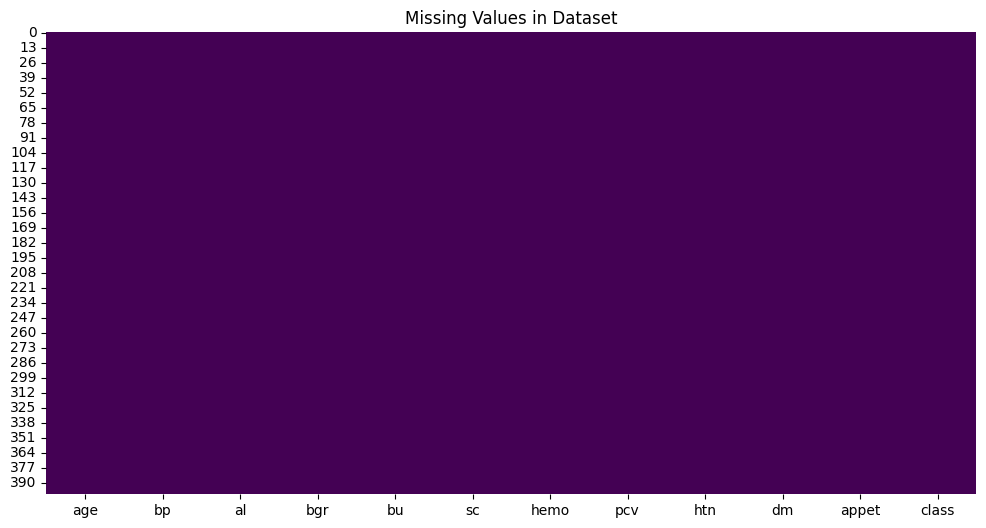

In [10]:
# Visualize Missing Data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Dataset')
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a int

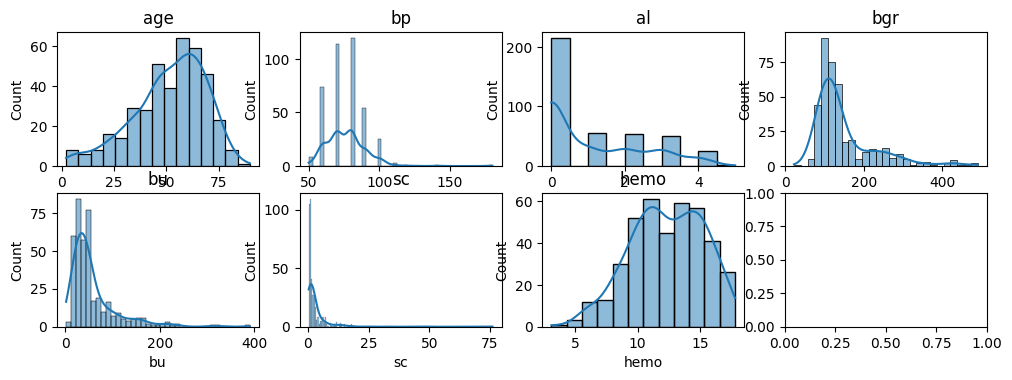

In [11]:
# Feature Distribution Plot
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

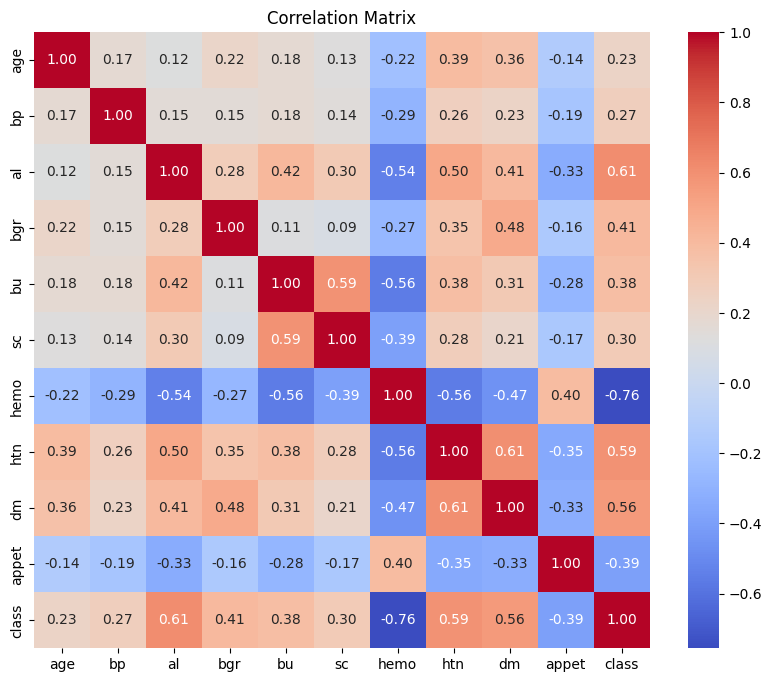

In [12]:
# Correlation Matrix Plot
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [13]:
# Separate target and features
target = df["class"]
source = df.drop(columns=["class"])

In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(source, target, test_size=0.05, random_state=42)


In [15]:
# Apply SMOTE for balancing
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


In [16]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Train a Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [22]:

# Cross-validation with 10 folds
cv_results = cross_validate(lr, source, target, cv=10, return_train_score=True)


C:\Users\Parth\anaconda_new\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Parth\anaconda_new\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [23]:
print( cv_results)

{'fit_time': array([0.01599908, 0.01708388, 0.01800013, 0.01654959, 0.01708388,
       0.01694012, 0.01212049, 0.00702643, 0.00707269, 0.00699925]), 'score_time': array([0.00200129, 0.00192213, 0.00200963, 0.00200224, 0.00295496,
       0.00200152, 0.0009222 , 0.00192451, 0.0020299 , 0.00106025]), 'test_score': array([1.   , 0.975, 1.   , 1.   , 0.975, 0.975, 0.95 , 1.   , 0.975,
       0.975]), 'train_score': array([0.98888889, 0.99166667, 0.98611111, 0.98611111, 0.99166667,
       0.98888889, 0.98611111, 0.98888889, 0.98888889, 0.98611111])}


In [19]:
# Save the model
joblib.dump(lr, "kidney_disease_model.pkl")

['kidney_disease_model.pkl']

In [20]:
# Print Cross-validation results summary
print("Average Training Score:", np.mean(cv_results['train_score']))
print("Average Test Score:", np.mean(cv_results['test_score']))

Average Training Score: 0.9883333333333333
Average Test Score: 0.9824999999999999
